In [1]:
!pip install tensorflow

In [4]:
!pip install matplotlib

In [5]:
!pip install imutils 

  Using cached imutils-0.5.4-py3-none-any.whl


In [7]:
!pip install scikit-learn

In [9]:
!pip install opencv-python

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ---- ----------------------------------- 1.6/12.6 MB 10.5 MB/s eta 0:00:02
   -------- ------------------------------- 2.6/12.6 MB 6.3 MB/s eta 0:00:02
   --------- ------------------------------ 2.9/12.6 MB 5.1 MB/s eta 0:00:02
   ----------- ---------------------------- 3.7/12.6 MB 4.2 MB/s eta 0:00:03
   ------------- -------------------------- 4.2/12.6 MB 3.9 MB/s eta 0:00:03
   -------------- ------------------------- 4.7/12.6 MB 3.8 MB/s eta 0:00:03
   ----------------- ---------------------- 5.5/12.6 MB 3.8 MB/s eta 0:00:02
   ------------------- -------------------- 6.3/12.6 MB 3.7 MB/s eta 0:00:02
   ------------------------ --------------- 7.6/12.6 MB 4.0 MB/s eta 0:00:02
   --------------------------- ------------ 8.7/12.6 MB 4.1 MB/s eta 0:00:01
   -----

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


In [23]:
!pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
from tensorflow.keras.preprocessing.image import img_to_array, load_img 
from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelBinarizer 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from imutils import paths 
import matplotlib.pyplot as plt 
import numpy as np 
import os 

In [13]:
#initialize the initial learning rate, number of epochs to train for, and batch size 
INIT_LR = 1e-4 
EPOCHS = 20 
BS = 32 

DIRECTORY = r"D:\Face-Mask-Detection-System\dataset"
CATEGORIES = ["with_mask", "without_mask"] 

In [14]:
#grab the list of images in pur dataset directory, then initialize
#the list of data and class images 
print("[INFO] loading images...") 

data = [] 
labels = []

for category in CATEGORIES: 
    path = os.path.join(DIRECTORY, category) 
    for img in os.listdir(path):
        img_path = os.path.join(path, img) 
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image) 
        image = preprocess_input(image) 
        
        data.append(image) 
        labels.append(category)

[INFO] loading images...


In [16]:
#perform one-hot encoding on the labels 
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels) 

(trainX, testX, trainY, testY) = train_test_split(data,labels,test_size=0.20, stratify=labels, random_state=42)

In [17]:
#construct the training image generator for data augmentation 
aug = ImageDataGenerator(
    rotation_range=20, 
    zoom_range=0.15, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest") 

In [18]:
#load the MobileNetV2 network, ensuring the head FC layer sets are left off 
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))) 

C:\Users\sumit bansal\AppData\Local\Temp\ipykernel_16456\3003596590.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
#construct the head of the model that will be placed on top of base model 
headModel = baseModel.output 
headModel = AveragePooling2D(pool_size=(7, 7))(headModel) 
headModel = Flatten(name="flatten")(headModel) 
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [20]:
#place the head FC model on top of the base model(this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [21]:
#loop over all the layers in the base model and freeze them so they will not be updated during the first training process 
for layer in baseModel.layers:
    layer.trainable = False 

In [24]:
#compile our model 
print("[INFO] compiling model...") 
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [26]:
#train the head of the network 
print("[INFO] training head........")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS), 
    steps_per_epoch=len(trainX) //BS,
    validation_data=(testX, testY), 
    validation_steps=len(testX) //BS, 
    epochs=EPOCHS)

[INFO] training head........


D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7939 - loss: 0.4504

D:\Anaconda\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


188/188 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.7945 - loss: 0.4495 - val_accuracy: 0.9735 - val_loss: 0.0944
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 217ms/step - accuracy: 0.9688 - loss: 0.1183 - val_accuracy: 0.9735 - val_loss: 0.0939
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.9714 - loss: 0.1035 - val_accuracy: 0.9775 - val_loss: 0.0653
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 227ms/step - accuracy: 0.9375 - loss: 0.1275 - val_accuracy: 0.9775 - val_loss: 0.0649
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9767 - loss: 0.0733 - val_accuracy: 0.9821 - val_loss: 0.0529
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 0.9821 - val_loss: 0.0528
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.9805 - loss: 0.0622 - val_accuracy: 0.9821 - val_loss: 0.0477
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 219ms/step - accuracy: 0.9375 - loss: 0.1523 - val_accurac

In [27]:
#make predictions on the testing set 
print("[INFO] evaluating network......") 
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network......
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 745ms/step


In [28]:
#for each image in the testing set we need to find the index of the label with corresponding largest predicted probability 
predIdxs = np.argmax(predIdxs, axis=1)

In [30]:
#show a nicely formatted classification report 
from sklearn.metrics import classification_report

# Assuming 0 = with_mask, 1 = without_mask
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=["with_mask", "without_mask"]))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       745
without_mask       0.99      0.99      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



In [32]:
#serialise the model to disk 
print("[INFO] saving mask detector model.....")
model.save("mask_detector.h5")

[INFO] saving mask detector model.....


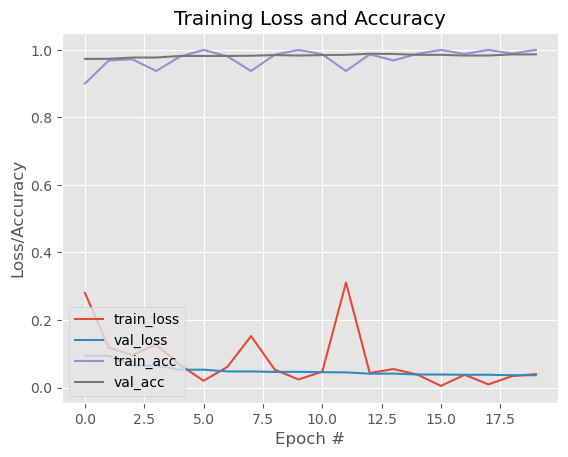

In [33]:
#plot the training loss and accuracy 
N = EPOCHS
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")  # Fix typo: "lower_left" → "lower left"
plt.savefig("plot.png")
plt.show()

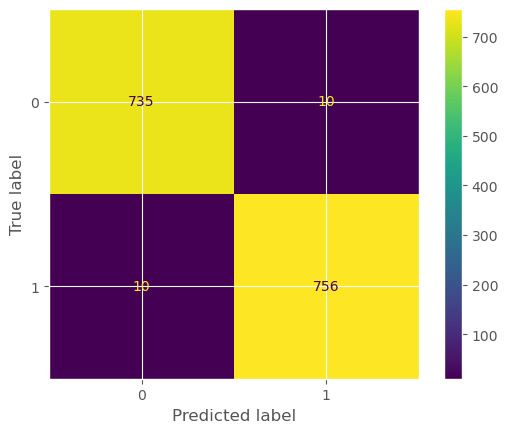

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot()
plt.show()